In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import words
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sn
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [3]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
data = data.rename(columns = {'v1':'Label','v2':'Text'})
data['length'] = data['Text'].apply(len)
data['word_count'] = data['Text'].apply(lambda x: len(str(x).split(" ")))
data.head()

,Label,Text,length,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


In [4]:
data.Label.value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

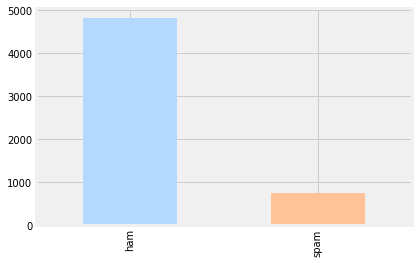

In [5]:
data['Label'].value_counts().plot(kind= 'bar', color= ["#b3d9ff", "#ffc299"])
#plt.title('Number of messages in data')
plt.show()

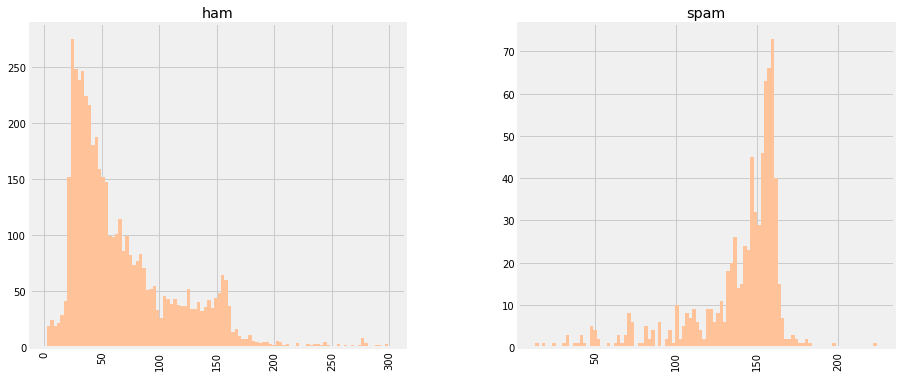

In [6]:
data1= data.loc[data['length'] <300]
ax=data1.hist(column='length', by='Label', bins=100,figsize=(15,6),color= ["#ffc299"])

#data.hist(column='word_count', by='Label', bins=20,figsize=(15,6))

#plt.title('Histogram of length of texts in data')
plt.show()

In [7]:
stop_words = stopwords.words('english')
spam_Texts=data.loc[data['Label'] == 'spam']['Text']
ham_Texts=data.loc[data['Label'] == 'ham']['Text']

def process_Text(Text):  
    words_list = Text.lower() # lowercase
    words_list = word_tokenize(words_list) # tokenization
    words_list = [word for word in words_list if word.isalpha()]
    words_list = [word for word in words_list if len(word) > 1] # non absurd words_list          
    words_list = [word for word in words_list if word not in stop_words] # non stop words_list
    #words_list = [word for word in words_list if word in words.words()] # english words_list
    words_list = [PorterStemmer().stem(word) for word in words_list] # stemming
    return words_list
def count_processed_words(data):
    counter = collections.OrderedDict()
    for Text in data:
        words_list = process_Text(Text)
        for word in set(words_list):           
            if word in counter:
                counter[word] += 1
            else:
                counter[word] = 1
    return counter







In [8]:
spam_words = count_processed_words(spam_Texts)
ham_words = count_processed_words(ham_Texts)
#all_words = collections.OrderedDict(((k, spam_words[k] + ham_words[k]) if k in ham_words 
 #                                    else (k,spam_words[k]) for k in spam_words ))

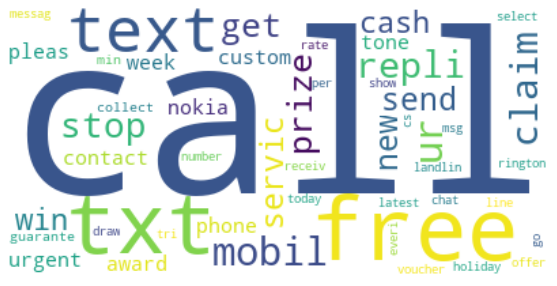

In [9]:
wc = WordCloud(background_color="white", max_words=50,max_font_size=400)

wc.generate_from_frequencies(spam_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

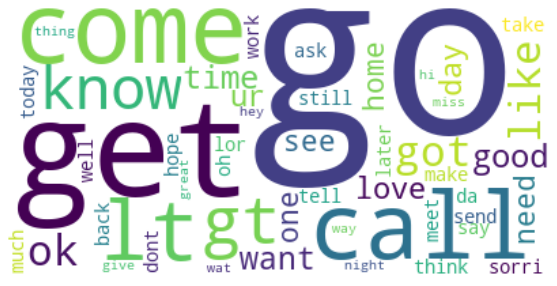

In [10]:
wc = WordCloud(background_color="white", max_words=50,max_font_size=400)

wc.generate_from_frequencies(ham_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [57]:
def test_train_split(data,split=0.75):
    train=data.sample(frac=split,random_state=100) 
    test=data.drop(train.index)
    return train,test

train,test=test_train_split(data)
Train_spam_Texts=train.loc[data['Label'] == 'spam']['Text']
Train_ham_Texts=train.loc[data['Label'] == 'ham']['Text']
spam_words = count_processed_words(Train_spam_Texts)
ham_words = count_processed_words(Train_ham_Texts)
all_words = count_processed_words(train['Text'])

In [51]:
def is_spam(Text, k=0,s=0, p=0.5, probability=False):

    n = 0
    spam_freq = 0
    ham_freq = 0
    spaminess_of_word=0
    for word in process_Text(Text):
        
        if word in spam_words.keys(): 
            # count of spam Texts containing the word / count of all Texts containing the word
            spam_freq = (spam_words[word] / all_words[word])
            
        if word in ham_words.keys():
            # count of ham Texts containing the word / count of all Texts containing the word
            ham_freq = (ham_words[word] / all_words[word])
            
        # if word is not in trained dataset we ignore it
        if word not in all_words.keys():
            all_words[word]=0
         

        if  all_words[word]!=0 or s!=0 :
            spaminess_of_word = (spam_freq + k ) / (spam_freq  + ham_freq +(2*k))
            corr_spaminess = (s * p + all_words[word] * spaminess_of_word) / (s + all_words[word])            
            n += np.log(1 - corr_spaminess) - np.log(corr_spaminess)
    spam_result = 1 / (1 + np.e**n)
    
    if probability:
        print(f'Spam probability: {spam_result*100:.2f}%')
    elif spam_result > 0.5:    
        return 'spam'
    else:
        return 'ham'

In [13]:
all_words['hi']

79

In [14]:
is_spam('xxxxxxxxx')

'ham'

In [58]:
y_actual=test['Label']
y_pred=[is_spam(text,k=1) for text in test['Text']]
cm=confusion_matrix(y_actual, y_pred, labels=["spam", "ham"])
Labels=['spam','ham']
df_cm = pd.DataFrame(cm, index = [i for i in Labels ],
                  columns = [i for i in Labels])
print(df_cm)
print(classification_report(y_actual, y_pred))
print(f"Accuracy: {accuracy_score(y_actual, y_pred)*100:.2f}%\n")

      spam   ham
spam   124    46
ham     14  1209
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98      1223
        spam       0.90      0.73      0.81       170

   micro avg       0.96      0.96      0.96      1393
   macro avg       0.93      0.86      0.89      1393
weighted avg       0.96      0.96      0.95      1393

Accuracy: 95.69%



In [46]:
is_spam("call me now to win a free house!")

'spam'

In [47]:
is_spam("call me now to get a free house!")

'ham'

In [26]:
is_spam("Hey, Call me when you are free at home")

'ham'

In [23]:
is_spam('call me when you are free')

'spam'